In [601]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [602]:
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [603]:

%pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

%pip install dowhy
from dowhy import CausalModel


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: tensorflow in c:\users\camar\appdata\local\programs\python\python310\lib\site-packages (2.20.0)




[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [604]:
#Chargement et nettoyages les données
import pandas as pd
df = pd.read_csv(
    r"D:\ProjetSyn\AirQualityUCI_with_quality_24h.csv",
    sep=",", decimal=".", header=0,
    encoding="utf-8"
)

import numpy as np
# Remplacer -200 par NaN (valeurs manquantes)
df.replace(-200, np.nan, inplace=True)

# Supprimer les lignes contenant des valeurs NaN
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df = df.drop(columns=['NMHC(GT)'])

# Convertir Date et Time en format datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Time'] = pd.to_timedelta(df['Time'])
df['Datetime'] = df['Date'] + df['Time']
df.set_index('Datetime', inplace=True)      
df.drop(columns=['Date', 'Time'], inplace=True)
df.head()  



,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,NO2_24h_mean,Qualite_Air_24h
Datetime,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,113.000000,Mauvais
2004-03-10 19:00:00,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,102.500000,Mauvais
2004-03-10 20:00:00,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,106.333333,Mauvais
2004-03-10 21:00:00,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,110.250000,Mauvais
2004-03-10 22:00:00,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,111.400000,Mauvais


In [605]:
#Résumé statistique
df.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,NO2_24h_mean
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000
mean,2.353567,1207.741838,10.772367,965.983777,143.501814,963.178053,100.259976,1600.506550,1045.691052,15.599859,49.049557,0.831851,74.135933
std,1.409496,241.826753,7.417127,266.413137,81.829717,265.906153,31.493823,302.290036,400.130277,4.825555,15.266995,0.178506,44.727772
min,0.300000,752.500000,0.542781,447.500000,12.000000,461.250000,19.000000,955.000000,263.000000,6.275000,14.900000,0.402317,-189.208333
25%,1.300000,1016.875000,4.804320,753.500000,81.000000,768.875000,78.500000,1369.125000,759.500000,11.875000,36.700000,0.718949,72.916667
50%,2.000000,1172.000000,9.125831,944.250000,128.000000,920.000000,99.000000,1556.250000,1009.000000,15.025000,49.550000,0.817693,83.208333
75%,3.100000,1380.250000,14.803204,1142.375000,187.000000,1131.000000,122.000000,1783.375000,1319.750000,18.350000,60.525001,0.927524,94.562500
max,8.100000,2039.750000,39.202340,1754.250000,478.000000,1934.500000,196.000000,2679.000000,2358.500000,30.000000,83.224998,1.485238,113.791667



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


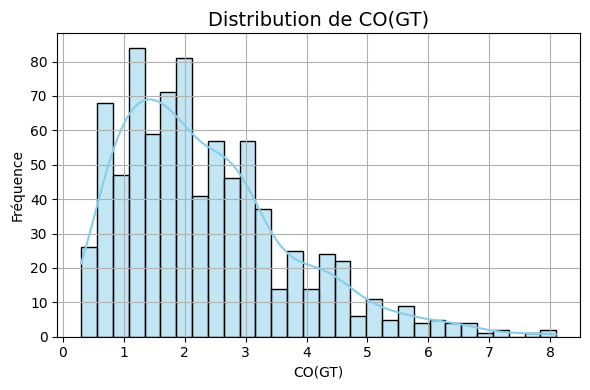

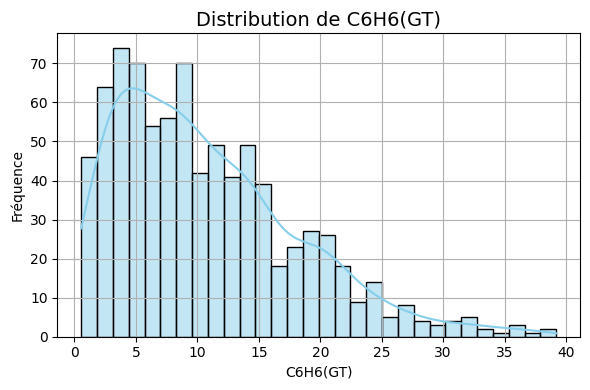

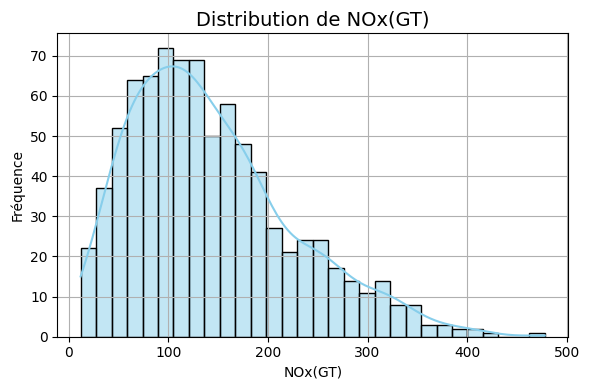

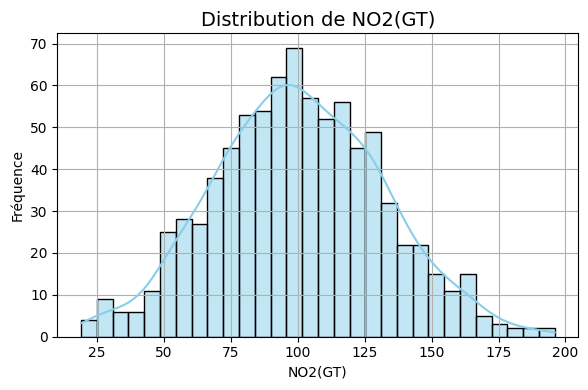

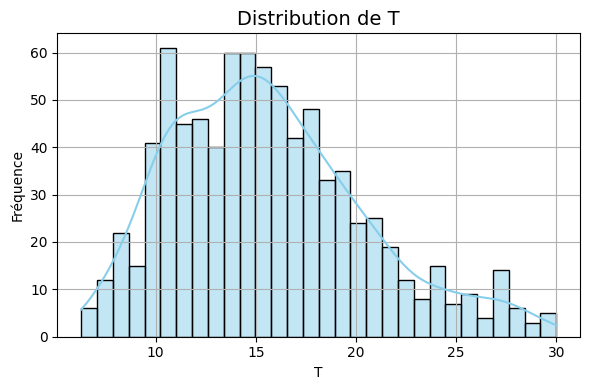

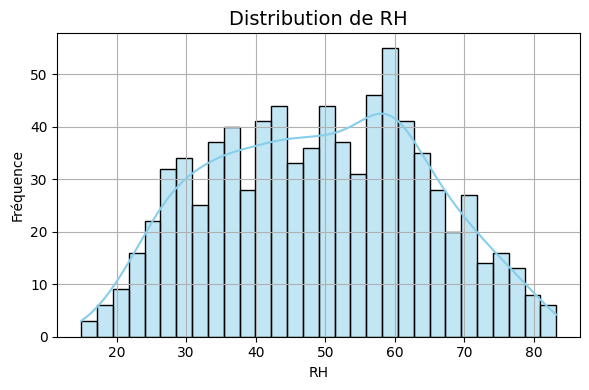

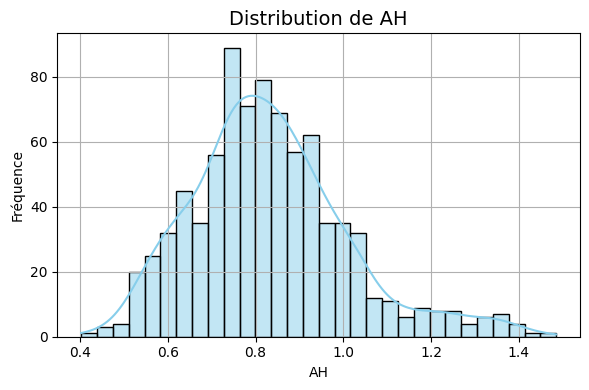

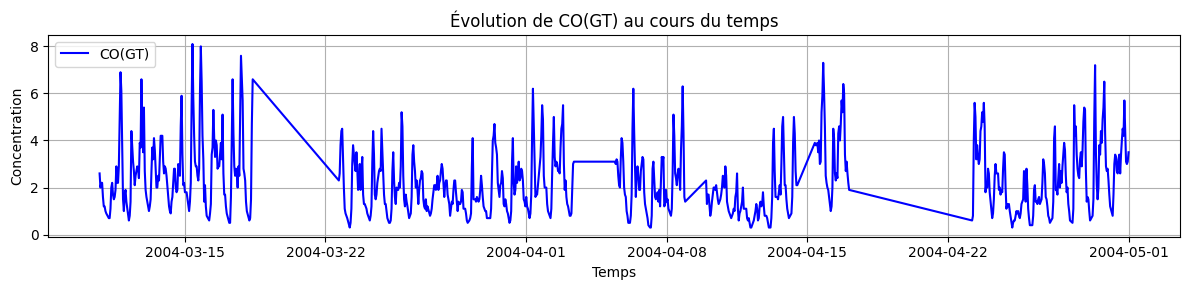

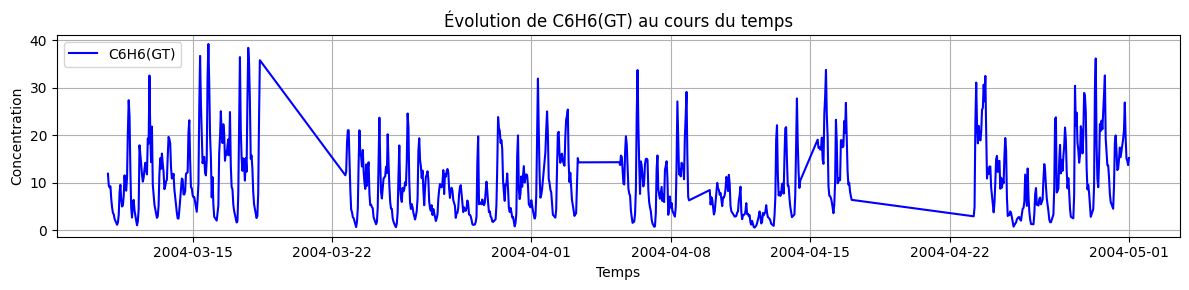

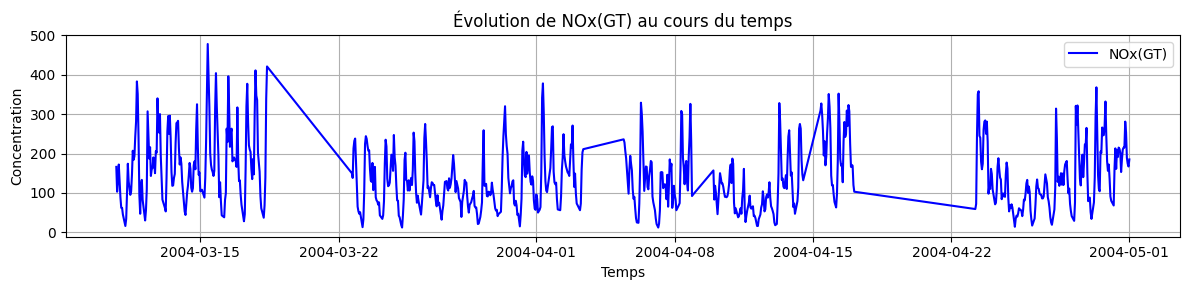

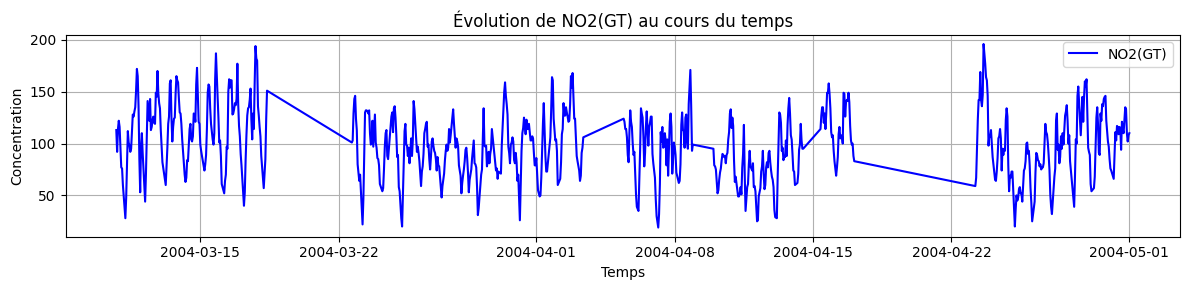

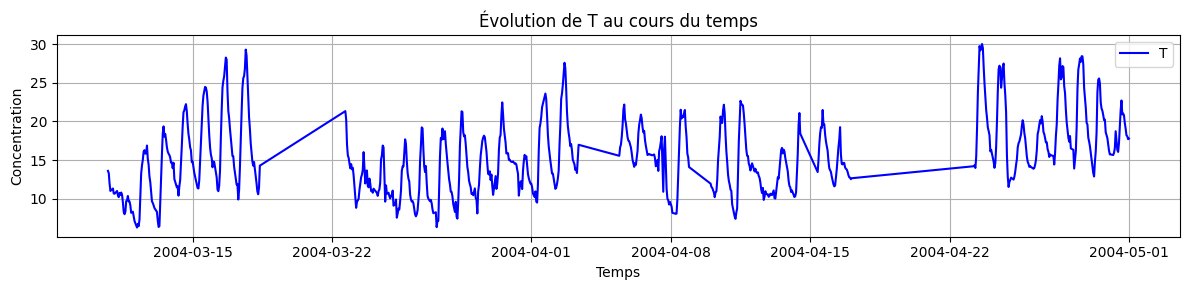

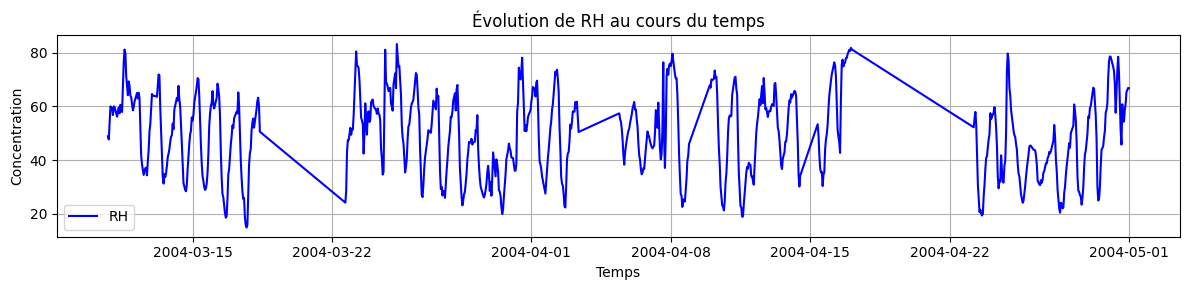

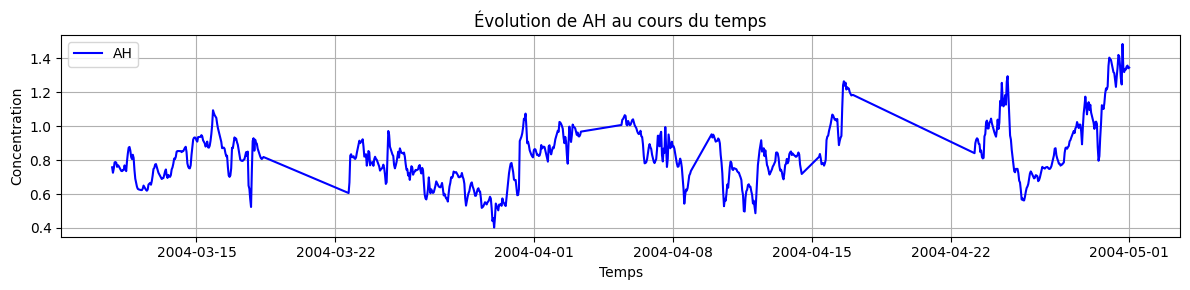

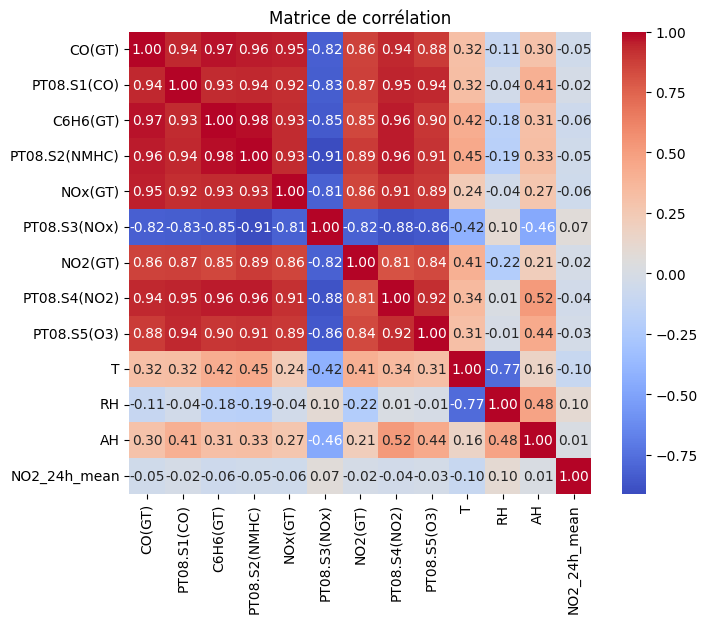

In [606]:

# Analyse exploratoire des données
%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
polluants = ['CO(GT)','C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'T','RH','AH']

# Histogramme pour chaque polluant
for col in polluants:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution de {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Création d'un graphique de type série temporelle pour visualiser l'évolution de CO(GT) dans le temps
for col in polluants:
    plt.figure(figsize=(12, 3))
    plt.plot(df.index, df[col], label=col, color='blue')
    plt.title(f"Évolution de {col} au cours du temps")
    plt.xlabel("Temps")
    plt.ylabel("Concentration")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Matrice de corrélation (colonnes numériques uniquement)
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matrice de corrélation')
plt.show()



In [607]:

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_sequences(data, target_col, seq_len=24):
    """
    Convertir le DataFrame en séquences à fenêtres glissantes.
    """
    X, y = [], []
    target = data[target_col].values
    features = data.values
    for i in range(len(data) - seq_len):
        X.append(features[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

def evaluate(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "MAPE": np.mean(np.abs((y_true - y_pred) / (y_true))) * 100
    }
    

In [608]:
%pip install torch

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Modèle TCN
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, stride=1,
                                        dilation=dilation, padding=(kernel_size-1)*dilation,
                                        dropout=dropout))
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        # x: [batch, seq, features] -> [batch, features, seq]
        x = x.transpose(1, 2)
        y = self.network(x)
        y = y[:, :, -1]  # Dernier pas de temps
        return self.fc(y)


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [609]:
# ---------------------- Transformer -------------------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x[:, -1, :]  # Dernier pas de temps
        return self.fc(x)


In [610]:
#Entraînement
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, device="cpu"):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).squeeze()
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb).squeeze()
                val_loss += criterion(pred, yb).item()
        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss/len(val_loader):.4f}")
    return model


In [611]:
# Validation croisée

from sklearn.model_selection import KFold

def cross_validate_model(ModelClass, X, y, k=5, epochs=10, device="cpu", **model_kwargs):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    metrics_list = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n--- Fold {fold + 1}/{k} ---")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                torch.tensor(y_train, dtype=torch.float32)),
                                  batch_size=32, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                              torch.tensor(y_val, dtype=torch.float32)),
                                batch_size=32)

        model = ModelClass(**model_kwargs)
        trained_model = train_model(model, train_loader, val_loader, device=device, epochs=epochs)

        with torch.no_grad():
            y_pred = trained_model(torch.tensor(X_val, dtype=torch.float32).to(device)).squeeze().cpu().numpy()
        metrics = evaluate(y_val, y_pred)
        metrics_list.append(metrics)

    avg_metrics = pd.DataFrame(metrics_list).mean().to_dict()
    return avg_metrics

In [612]:
# Préparer les séquences
target = "CO(GT)"
seq_len = 24
device = "cuda" if torch.cuda.is_available() else "cpu"

# Conserver uniquement les colonnes numériques pour la création des séquences
df_numeric = df.select_dtypes(include=[np.number])
X, y = create_sequences(df_numeric, target, seq_len=seq_len)

# ========== Hyperparamètres testés ==========
tcn_fn = lambda: TCN(num_inputs=X.shape[2], num_channels=[32, 32], kernel_size=3, dropout=0.2)
trans_fn = lambda: TimeSeriesTransformer(input_dim=X.shape[2], d_model=64, nhead=4, num_layers=2, dropout=0.1)

# ========== Évaluation croisée ==========
print("\nValidation croisée du modèle TCN...")
tcn_results = cross_validate_model(tcn_fn, X, y, k=3, epochs=10)
print("Résultats TCN:", tcn_results)

print("\nValidation croisée du modèle Transformer...")
transformer_results = cross_validate_model(trans_fn, X, y, k=3, epochs=10)
print("Résultats Transformer:", transformer_results)

# ========== Comparaison ==========
print("\nComparaison Finale des modèles :")
comparison = pd.DataFrame({
    "Modèle": ["TCN", "Transformer"],
    "RMSE": [tcn_results["RMSE"], transformer_results["RMSE"]],
    "MAE": [tcn_results["MAE"], transformer_results["MAE"]],
    "R2": [tcn_results["R2"], transformer_results["R2"]],
    "MAPE (%)": [tcn_results["MAPE"], transformer_results["MAPE"]]
    })
print(comparison.round(4))




Validation croisée du modèle TCN...

--- Fold 1/3 ---
Epoch 1/10, Val Loss: 357.8169
Epoch 2/10, Val Loss: 499.4714
Epoch 3/10, Val Loss: 190.7732
Epoch 4/10, Val Loss: 168.2999
Epoch 5/10, Val Loss: 150.7801
Epoch 6/10, Val Loss: 137.3806
Epoch 7/10, Val Loss: 126.7452
Epoch 8/10, Val Loss: 113.0125
Epoch 9/10, Val Loss: 106.2968
Epoch 10/10, Val Loss: 97.2683

--- Fold 2/3 ---
Epoch 1/10, Val Loss: 1013.8290
Epoch 2/10, Val Loss: 225.9262
Epoch 3/10, Val Loss: 100.4373
Epoch 4/10, Val Loss: 57.3405
Epoch 5/10, Val Loss: 64.3186
Epoch 6/10, Val Loss: 46.1078
Epoch 7/10, Val Loss: 56.4473
Epoch 8/10, Val Loss: 41.1492
Epoch 9/10, Val Loss: 24.0875
Epoch 10/10, Val Loss: 19.7788

--- Fold 3/3 ---
Epoch 1/10, Val Loss: 211.7436
Epoch 2/10, Val Loss: 147.8294
Epoch 3/10, Val Loss: 83.9755
Epoch 4/10, Val Loss: 77.3300
Epoch 5/10, Val Loss: 74.2213
Epoch 6/10, Val Loss: 71.5484
Epoch 7/10, Val Loss: 67.3347
Epoch 8/10, Val Loss: 60.9069
Epoch 9/10, Val Loss: 57.5015
Epoch 10/10, Val Loss:

In [646]:
%pip install tigramite

import matplotlib.pyplot as plt
from tigramite.data_processing import DataFrame as TigramiteDF
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.pcmci import PCMCI
import tigramite.plotting as tp

# DÉCOUVERTE CAUSALE : PCMCI

def run_pcmci(df, maxlag=6, alpha=0.05):
    """
    Exécuter la découverte causale PCMCI sur un DataFrame de séries temporelles.
    """
    data = df.values
    var_names = list(df.columns)
    
    dataframe = TigramiteDF(data, var_names=var_names)
    parcorr = ParCorr(significance='analytic')
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr)

    results = pcmci.run_pcmci(tau_max=maxlag, pc_alpha=alpha)

    # Affichage des liens significatifs                          
    pcmci.print_significant_links(
        p_matrix=results['p_matrix'],
        val_matrix=results['val_matrix'],
        alpha_level=alpha
    )

    # Il faut fournir tau_min et tau_max
    graph = pcmci.get_graph_from_pmatrix(
        p_matrix=results['p_matrix'],
        alpha_level=alpha,
        tau_min=1,
        tau_max=maxlag
    )

    # Générer et afficher le graphe résultant
    tp.plot_graph(
        graph,
        var_names=var_names,
        figsize=(8, 8)
    )
    plt.title("PCMCI")
    plt.tight_layout()
    plt.show()

    return results, graph


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [643]:
%pip install lingam

import networkx as nx
from lingam import DirectLiNGAM

# DÉCOUVERTE CAUSALE : LiNGAM

def run_lingam(df):
    """
    Applique l’algorithme DirectLiNGAM pour identifier des relations causales sur des données contemporaines.
    """
    model = DirectLiNGAM()
    model.fit(df.values)
    
    adj_matrix = model.adjacency_matrix_
    var_names = df.columns
    
    print("Matrice d’adjacence LiNGAM :\n", adj_matrix)
    
    # # Construire le graphe acyclique orienté (DAG)
    G = nx.DiGraph()
    for i, src in enumerate(var_names):
        for j, tgt in enumerate(var_names):
            if adj_matrix[i, j] != 0:
                G.add_edge(src, tgt, weight=adj_matrix[i, j])
    
    # Visualiser le graphe acyclique orienté (DAG)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", arrowsize=20)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
    plt.title("DAG LiNGAM")
    plt.tight_layout()
    plt.show()
    
    return adj_matrix


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [644]:
import dowhy
from dowhy import CausalModel

def build_scm(df, treatment, outcome, common_causes):
    """
    Construire un modèle causal structurel avec DoWhy.
    """
    model = CausalModel(
        data=df,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes
    )

    identified_estimand = model.identify_effect()
    print("Effet identifié:\n", identified_estimand)

    estimate_lr = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    print(f"Backdoor OLS ATE ({treatment} -> {outcome}): {float(estimate_lr.value):.6f}")

    # Réfutations utiles pour la robustesse
    ref1 = model.refute_estimate(identified_estimand, estimate_lr, method_name="placebo_treatment_refuter")
    print("Refutation - placebo:\n", ref1)
    ref2 = model.refute_estimate(identified_estimand, estimate_lr, method_name="data_subset_refuter")
    print("Refutation - subset:\n", ref2)
    
    try:
        ref3 = model.refute_estimate(
            identified_estimand, estimate_lr,
            method_name="add_unobserved_common_cause",
            # clés importantes pour éviter un classifieur :
            confounders_effect_on_treatment="linear",
            confounders_effect_on_outcome="linear",
            effect_strength_on_treatment=0.2,
            effect_strength_on_outcome=0.2,
            num_simulated_confounders=1,
            random_state=42
        )
        print("Refutation - Cause commune non observée (linéaire/linéaire):\n", ref3)
    except Exception as e:
        print("Avertissement: UCC (linear) indisponible avec cette version/config. Fallback -> add_random_common_cause.")
        print("Détail de l'exception:", e)
        ref3 = model.refute_estimate(
            identified_estimand, estimate_lr,
            method_name="add_random_common_cause"
        )
    
    model.view_model()  # Affiche le DAG

    return model, identified_estimand, estimate_lr
    


## Significant links at alpha = 0.05:

    Variable CO(GT) has 23 link(s):
        (C6H6(GT)  0): pval = 0.00000 | val =  0.951
        (PT08.S2(NMHC)  0): pval = 0.00000 | val =  0.930
        (PT08.S1(CO)  0): pval = 0.00000 | val =  0.926
        (PT08.S4(NO2)  0): pval = 0.00000 | val =  0.913
        (NOx(GT)  0): pval = 0.00000 | val =  0.889
        (PT08.S5(O3)  0): pval = 0.00000 | val =  0.867
        (NO2(GT)  0): pval = 0.00000 | val =  0.730
        (PT08.S3(NOx)  0): pval = 0.00000 | val = -0.707
        (PT08.S2(NMHC) -1): pval = 0.00000 | val =  0.483
        (RH  0): pval = 0.00000 | val =  0.187
        (C6H6(GT) -2): pval = 0.00001 | val = -0.156
        (PT08.S1(CO) -1): pval = 0.00007 | val =  0.139
        (PT08.S3(NOx) -2): pval = 0.00149 | val =  0.112
        (T -1): pval = 0.00160 | val = -0.111
        (PT08.S3(NOx) -5): pval = 0.00191 | val = -0.109
        (T  0): pval = 0.00595 | val = -0.097
        (PT08.S2(NMHC) -5): pval = 0.01111 | val =  0.089
     

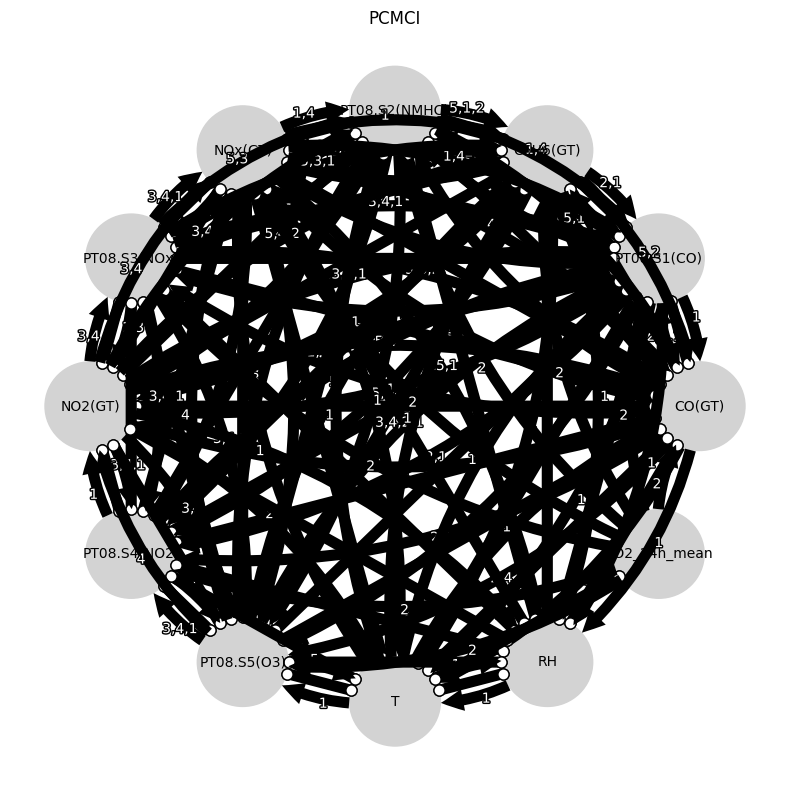

Matrice d’adjacence LiNGAM :
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.70457670e-01  3.17813356e-02  0.00000000e+00]
 [ 3.69829026e+01  0.00000000e+00 -8.39292997e+00  7.97637597e-01
   5.45003148e-01  2.36911996e-01  1.25474728e+00  0.00000000e+00
   0.00000000e+00  8.54828943e+00  4.07839921e+00  0.00000000e+00]
 [ 4.88800428e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.28742459e-01  1.66357463e-02  0.00000000e+00]
 [ 1.84309778e+01  0.00000000e+00  3.10271052e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  4.22012537e+00  4.94631242e-01  7.47727146e-02]
 [ 3.25411447e+01  0.00000000e+00  0.00000000e+00  9.95401450e-02
   0.00000000e+00  0.00000000e+00  3.80304451e-01  0.00000000e+00
   0.00000000e+00 -2.44208528e+00  0.00000

C:\Users\camar\AppData\Local\Temp\ipykernel_17688\2058139035.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


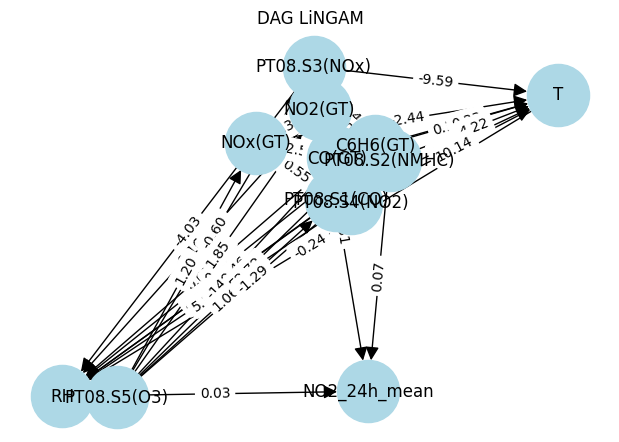


 Modèle Causal Structurel (SCM) et Estimation par la méthode du Backdoor ...
Effet identifié:
 Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                                             ↪
────(E[CO(GT)|PT08.S1(CO),C6H6(GT),NO2(GT),RH,NOx(GT),PT08.S5(O3),PT08.S4(NO2) ↪
d[T]                                                                           ↪

↪                                           
↪ ,NO2_24h_mean,PT08.S2(NMHC),PT08.S3(NOx)])
↪                                           
Estimand assumption 1, Unconfoundedness: If U→{T} and U→CO(GT) then P(CO(GT)|T,PT08.S1(CO),C6H6(GT),NO2(GT),RH,NOx(GT),PT08.S5(O3),PT08.S4(NO2),NO2_24h_mean,PT08.S2(NMHC),PT08.S3(NOx),U) = P(CO(GT)|T,PT08.S1(CO),C6H6(GT),NO2(GT),RH,NOx(GT),PT08.S5(O3),PT08.S4(NO2),NO2_24h_mean,PT08.S2(NMHC),PT08.S3(NOx))

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No s

c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is depr

Refutation - placebo:
 Refute: Use a Placebo Treatment
Estimated effect:-0.017502163707471485
New effect:-5.417888360170764e-14
p value:0.0



c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is depr

Refutation - subset:
 Refute: Use a subset of data
Estimated effect:-0.017502163707471485
New effect:-0.017632020515955898
p value:0.94

Refutation - Cause commune non observée (linéaire/linéaire):
 Refute: Add an Unobserved Common Cause
Estimated effect:-0.017502163707471485
New effect:-0.031996132321976845



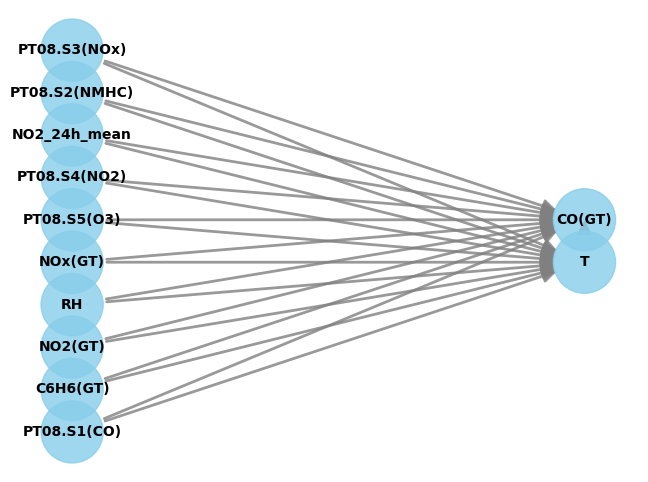

In [648]:


# Sélectionner un sous-ensemble de variables pour la découverte causale
subset = df[["CO(GT)","PT08.S1(CO)", "C6H6(GT)","PT08.S2(NMHC)","NOx(GT)", "PT08.S3(NOx)","NO2(GT)", "PT08.S4(NO2)","PT08.S5(O3)","T", "RH", "NO2_24h_mean"]].dropna()


# 1. PCMCI
pcmci_results, pcmci_graph = run_pcmci(subset, maxlag=6, alpha=0.05)
# 2. LiNGAM
lingam_adj = run_lingam(subset)

# 3. Exemple de SCM : définir traitement, résultat et covariables
print("\n Modèle Causal Structurel (SCM) et Estimation par la méthode du Backdoor ...")
scm, estimand, estimate_lr = build_scm(
    subset, treatment="T", outcome="CO(GT)",
    common_causes=["PT08.S1(CO)", "C6H6(GT)","PT08.S2(NMHC)","NOx(GT)", "PT08.S3(NOx)","NO2(GT)", "PT08.S4(NO2)","PT08.S5(O3)","RH", "NO2_24h_mean"]#"C6H6(GT)", "NOx(GT)","NO2(GT)", "RH"
)




In [649]:
%pip install econml scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [650]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LassoCV
import pickle

# Sélectionner les variables en fonction des résultats de PCMCI/LiNGAM
features = [ "C6H6(GT)", "NOx(GT)","NO2(GT)"] 
treatment = "T"
outcome = "CO(GT)"

X = subset[features]
T_var = subset[[treatment]].values
Y = subset[outcome].values

# --- Sauvegarder les noms de colonnes ---
X_feature_names = list(X.columns)
with open("feature_names.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)


# Diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T_var, Y, test_size=0.2, random_state=42)#(X, T_var, Y, test_size=0.2, random_state=42)

# Appliquer une mise à l’échelle des variables
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)


In [651]:
# --- Sauvegarder les noms de colonnes ---
import pickle

with open("feature_names.pkl", "rb") as f:
    feature_names = pickle.load(f)


print("Noms des variables utilisés dans Streamlit :", feature_names)


Noms des variables utilisés dans Streamlit : ['C6H6(GT)', 'NOx(GT)', 'NO2(GT)']


c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean CATE (effect of T on Y): -0.018039027463791227
ATE: -0.0180, 95% IC=(-0.0312, -0.0049)


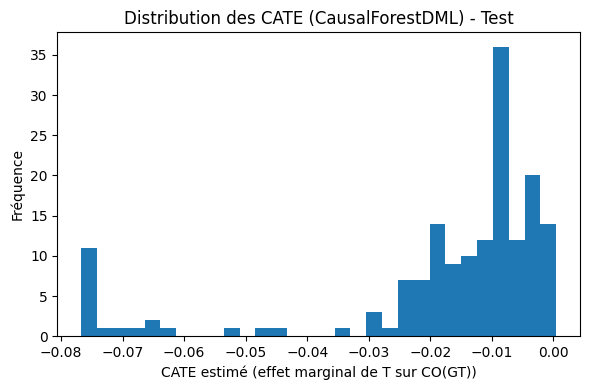

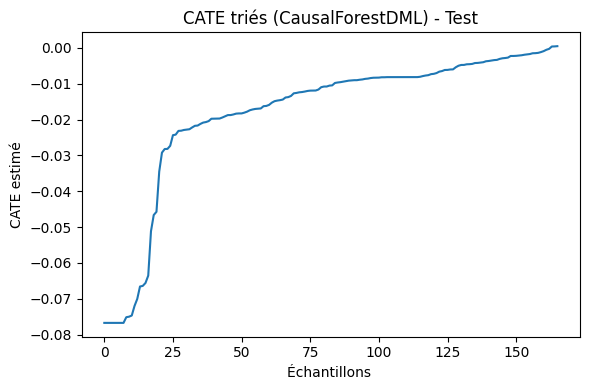

In [652]:
import numpy as np
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Créer et paramétrer le modèle de causal forest
causal_forest = CausalForestDML(
    model_t=RandomForestRegressor(),
    model_y=RandomForestRegressor(),
    discrete_treatment=False,
    cv=3,
    n_estimators=100,
    min_samples_leaf=10,
    random_state=42
)

# Entraîner (ajuster) le modèle sur les données d'entraînement 
causal_forest.fit(Y_train, T_train, X=X_train_s)

# ---- 1. # Estimation de l’effet du traitement ----
# Effet moyen conditionnel du traitement (CATE)
cate_test  = causal_forest.effect(X_test_s)

print("Mean CATE (effect of T on Y):", np.mean(cate_test))

# Intervalle de confiance des effets
lb, ub = causal_forest.effect_interval(X_test_s)

# ---- 2. Effet moyen du traitement (ATE) ----
ate = causal_forest.ate(X_test_s)
ate_lb, ate_ub = causal_forest.ate_interval(X_test_s)
print(f"ATE: {ate:.4f}, 95% IC=({ate_lb:.4f}, {ate_ub:.4f})")

# Figures CATE
plt.figure(figsize=(6,4))
plt.hist(cate_test, bins=30)
plt.xlabel("CATE estimé (effet marginal de T sur CO(GT))")
plt.ylabel("Fréquence")
plt.title("Distribution des CATE (CausalForestDML) - Test")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.sort(cate_test))
plt.xlabel("Échantillons ")
plt.ylabel("CATE estimé")
plt.title("CATE triés (CausalForestDML) - Test")
plt.tight_layout()
plt.show()

In [653]:
import pandas as pd

# Convert arrays to DataFrames first
X_train_aug = pd.DataFrame(X_train, columns=feature_names)  # feature_names que tu as sauvegardé
X_test_aug = pd.DataFrame(X_test, columns=feature_names)


print("Forme des données d'entrainement augmentées:", X_train_aug.shape)
print("Forme des données de test augmentées:", X_test_aug.shape)


Forme des données d'entrainement augmentées: (661, 3)
Forme des données de test augmentées: (166, 3)


In [654]:
# ==============================================================================
# Modèle final : Causal Forest + Deep Learning
# ==============================================================================
import numpy as np
import pandas as pd
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# ------------------------------------------------------------------------------
# 1: Entraîner Causal Forest
# ------------------------------------------------------------------------------

causal_forest = CausalForestDML(
    model_t=RandomForestRegressor(),
    model_y=RandomForestRegressor(),
    discrete_treatment=False,
    cv=3,
    n_estimators=100,
    min_samples_leaf=10,
    random_state=42
)
# Entraîner le modèle sur l’ensemble d’apprentissage 
causal_forest.fit(Y_train, T_train, X=X_train_s)

# 2: Estimer les CATE sur train/test
cate_train = causal_forest.effect(X_train_s)
cate_test = causal_forest.effect(X_test_s)

# 3: Construire les features "augmentées":
X_train_aug = pd.DataFrame(X_train, columns=feature_names)  # feature_names que tu as sauvegardé
X_test_aug = pd.DataFrame(X_test, columns=feature_names)

# ------------------------------------------------------------------------------
# 4: Modèle de Deep Learning
# ------------------------------------------------------------------------------

#  Construire un réseau de neurones feedforward simple
input_dim = X_train_aug.shape[1]

dl_model = Sequential()
dl_model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
dl_model.add(Dropout(0.1))
dl_model.add(Dense(32, activation='relu'))
dl_model.add(Dense(1)) 
dl_model.compile(optimizer='adam', loss='mse')

# Early stopping pour éviter l’overfit
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraîner le modèle sur les variables augmentées
history = dl_model.fit(
    X_train_aug, Y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

# ------------------------------------------------------------------------------
# 4: Évaluation du modèle
# ------------------------------------------------------------------------------

# Prédire sur l’ensemble de test
y_pred = dl_model.predict(X_test_aug).ravel()#X_test_aug

# Calcul des métriques d’évaluation du modèle
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)

print(f"\nPerformance du modèle final:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Epoch 1/50


c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 78.7375 - val_loss: 3.0779
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.8190 - val_loss: 2.3253
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.1216 - val_loss: 0.5014
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0621 - val_loss: 1.3912
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.0583 - val_loss: 1.0985
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7662 - val_loss: 0.4418
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0539 - val_loss: 0.4805
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6861 - val_loss: 0.3914
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1680 - val_loss: 0.2274
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5500 - val_loss: 0.4462
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4938 - val_loss: 0.3680
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1504 - val_loss: 0

In [655]:
import joblib
import pickle

# # Sauvegarder les modèles et les artefacts de prétraitement

dl_model.save("deep_model.keras")

# Utilisation d’un format hérité
dl_model.save("deep_model.h5")

# # Sauvegarder le modèle de Causal Forest
joblib.dump(causal_forest, "causal_forest.pkl")

# Sauvegarder le scaler et les noms des variables
joblib.dump(scaler, "scaler.pkl")



with open("feature_names.pkl", "wb") as f:
    pickle.dump(list(X_train_aug.columns), f)

print("Modèles et artefacts de prétraitement sauvegardés avec succès !")


Modèles et artefacts de prétraitement sauvegardés avec succès !
